In [93]:
import numpy as np
import random
import matplotlib.pyplot as plt
import copy
import warnings
warnings.filterwarnings('ignore')

from keras.datasets import fashion_mnist
(trainX, trainy), (testX, testy) = fashion_mnist.load_data()

In [96]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(trainX, trainy, test_size=0.3, random_state=42)

In [97]:
X_train = X_train.reshape(X_train.shape[0],-1).astype('float64')
X_val = X_val.reshape(X_val.shape[0],-1).astype('float64')
testX = testX.reshape(testX.shape[0],-1).astype('float64')

In [98]:
X_train.shape

(42000, 784)

In [11]:
def forgyInitialization(train,k):
    ans = []
    for _ in range(k):
        index = random.randint(0,train.shape[0]-1)
        ans.append(train[index])
    return np.array(ans)

In [12]:
def randomPartitionMethod(train,k):
    count = [0]*k
    InitialPoints = [np.zeros(train.shape[1])]*k
    for i in range(train.shape[0]):
        index = random.randint(0,k-1)
        count[index] += 1
        InitialPoints[index] = np.add(train[i],InitialPoints[index])
    for i in range(k):
        if(count[i] != 0):
            InitialPoints[i] = (InitialPoints[i]/count[i]).astype(int)
    return np.array(InitialPoints)

In [13]:
def samplePoint(arg):
    point_dist = copy.deepcopy(arg)
    totalDist = 0
    for p in point_dist:
        totalDist += p[1]
    for i in range(1,len(point_dist)):
        point_dist[i][1] += point_dist[i-1][1]
    #point_dist = point_dist.sort(key = lambda x: x[1])
    #print(point_dist)
    randNum = random.uniform(0,1)*totalDist
    #print("rand num is : ",randNum)
    for i in range(len(point_dist)):
        if randNum <= point_dist[i][1]:
            return point_dist[i][0]

In [14]:
def kmeansPlusPlus(train,k):
    #need to select
    ans = []
    for _ in range(k):
        if len(ans) == 0:
            index = random.randint(0,train.shape[0]-1)
            ans.append(train[index].tolist())
        else:
            point_dist = []
            for p in train: #p is a np array
                if p.tolist() not in ans:
                    #calculate all the distances and select the min
                    minDist = float('inf')
                    for a in ans:
                        distSquare = np.sum(np.square(np.subtract(a,p)))
                        minDist = min(distSquare,minDist)
                    point_dist.append([p,minDist]) 
            nextPoint = samplePoint(point_dist)#list of tuple(np.array,distSquare)
            ans.append(nextPoint.tolist())
    return np.array(ans)

In [15]:
def getMSE(X_train,initialPoints,predictions):
    SE = 0
    for i in range(len(X_train)):
        #error = np.sum(np.square(np.subtract(X_train[i],initialPoints[predictions[i]])))
        #print("row :",X_train[i]," pred :", initialPoints[predictions[i]]," error is :",error)
        sub = np.subtract(X_train[i],initialPoints[predictions[i]])
        #print("sub ",sub)
        #print("sub type :",sub.dtype)
        sqr_sub = np.square(sub,dtype=np.float64)
        #print("square :",sqr_sub)
        #print("sqr dtype :",sqr_sub.dtype)
        error = np.sum(sqr_sub)
        #print("error ",error)
        SE += error
    return SE/X_train.shape[0]

In [16]:
def getDistanceArray(trainRow,initialPoints,distType):
    if distType.lower() == "euclidean":
        sub_square = np.square(np.subtract(initialPoints,trainRow))
        return np.sqrt(np.sum(sub_square,axis=1))
    else:
        sub_abs = abs(np.subtract(initialPoints,trainRow))
        return np.sum(sub_abs,axis=1)

In [17]:
def updateInitialPoints(X_train,initialPoints,predictions):
    old = np.copy(initialPoints)
    count = [0]*initialPoints.shape[0]
    ans = np.zeros(initialPoints.shape)
    for i in range(X_train.shape[0]):
        clusterNum = predictions[i]
        count[clusterNum] += 1
        ans[clusterNum] = np.add(X_train[i],ans[clusterNum])
    #print(count)
    for i in range(initialPoints.shape[0]):
        if(count[i] != 0):
            ans[i] = (ans[i]/count[i]).astype(int)
        else:
            ans[i] = old[i]
    return ans

In [18]:
def getAvgDistance(cluster,point):
    #dist = np.sum(np.sqrt(np.sum(np.square(np.subtract(cluster,point),dtype=np.float64),axis=1)))
    sub = np.subtract(cluster,point,dtype=np.float64)
    #print("---sub---")
    #print(sub)
    
    sub_square = np.square(sub,dtype=np.float64)
    #print("---sub square---")
    #print(sub_square)
    
    sub_square_sum = np.sum(sub_square,axis=1,dtype=np.float64)
    #print("---sub square sum---")
    #print(sub_square_sum)
    
    sub_square_sum_sqrt = np.sqrt(sub_square_sum,dtype=np.float64)
    #print("---sub square sum sqrt---")
    #print(sub_square_sum_sqrt)
    
    sub_square_sum_sqrt_sum = np.sum(sub_square_sum_sqrt,dtype=np.float64)
    #print("---sub square sum sqrt sum---")
    #print(sub_square_sum_sqrt_sum)
    
    dist = sub_square_sum_sqrt_sum
    #print("tot dist is : ",dist)
    return dist/cluster.shape[0]

In [19]:
def getAvgDistanceOwnCluster(cluster,point):
    #dist = np.sum(np.sqrt(np.sum(np.square(np.subtract(cluster,point),dtype=np.float64),axis=1)))
    sub = np.subtract(cluster,point,dtype=np.float64)
    #print("---sub---")
    #print(sub)
    
    sub_square = np.square(sub,dtype=np.float64)
    #print("---sub square---")
    #print(sub_square)
    
    sub_square_sum = np.sum(sub_square,axis=1,dtype=np.float64)
    #print("---sub square sum---")
    #print(sub_square_sum)
    
    sub_square_sum_sqrt = np.sqrt(sub_square_sum,dtype=np.float64)
    #print("---sub square sum sqrt---")
    #print(sub_square_sum_sqrt)
    
    sub_square_sum_sqrt_sum = np.sum(sub_square_sum_sqrt,dtype=np.float64)
    #print("---sub square sum sqrt sum---")
    #print(sub_square_sum_sqrt_sum)
    
    dist = sub_square_sum_sqrt_sum
    #print("tot dist is : ",dist)
    return dist/(cluster.shape[0]-1)

In [20]:
#implement Kmeans from scratch
class Kmeans:
    def __init__(self,X_train,initialPoints,distType="euclidean"):
        self.X_train = X_train
        self.initialPoints = initialPoints
        self.distType = distType
    
    def getSMM(self):
        return self.currError
    
    def getSilhouteScore(self):
        numofClusters = self.initialPoints.shape[0]
        self.clusterScores = [[] for i in range(numofClusters)]
        clusters = [] # contains all the clusters
        for j in range(numofClusters):
            jthIndices = tuple([self.predictions==j])
            clusters.append(self.X_train[jthIndices])
        #for clus in clusters:
        #    print(clus)
        score = 0
        for i in range(self.X_train.shape[0]):
            currCluster = self.predictions[i]
            ownCluster = clusters[currCluster]
            #print("-"*20)
            #print(self.X_train[i]," belongs to ",ownCluster)
            a = getAvgDistanceOwnCluster(ownCluster,self.X_train[i])
            #print("dist from own cluster is : ",a)
            b = float('inf')
            for j in range(numofClusters):
                if j != currCluster:
                    dist = getAvgDistance(clusters[j],self.X_train[i])
                    #print("dist with cluster ",j," is : ",dist)
                    b=min(b,dist)
            currScore = ((b-a)/max(a,b))
            #print("curr cluster is : ",currCluster)
            self.clusterScores[currCluster].append(currScore)
            #print("curr score : ",currScore)
            score += currScore 
        for c in self.clusterScores:
            c.sort()
        self.silhouteScore = score/self.X_train.shape[0]
        return self.silhouteScore
            
    def train(self):
        prevError = 0
        for _ in range(100):
            self.predictions = np.zeros(self.X_train.shape[0],dtype=int)
            for i in range(self.X_train.shape[0]):
                distanceArray = getDistanceArray(self.X_train[i],self.initialPoints,self.distType)
                self.predictions[i] = np.argmin(distanceArray) # contains the curr cluster for X_train[i]
            self.currError = getMSE(self.X_train,self.initialPoints,self.predictions)
            #print("currError is : ",self.currError)
            if(abs(prevError-self.currError)/100<2):
                break
            prevError = self.currError
            self.initialPoints = updateInitialPoints(self.X_train,self.initialPoints,self.predictions)

In [21]:
def plotShiloute(classifier,title):
    plt.figure()
    clusters = classifier.clusterScores
    finalList = []
    for c in clusters:
        finalList += [0]*30 + c + [0]*30
    plt.plot(finalList)
    plt.title(title)
    plt.axhline(y=classifier.silhouteScore,color='r')

In [22]:
classifiers_foggy_euclidean = []
classifiers_rand_euclidean = []
classifiers_kpp_euclidean = []
classifiers_foggy_man = []
classifiers_rand_man = []
classifiers_kpp_man = []
for k in range(2,13):
    initialPoints_foggy = forgyInitialization(X_train,k)
    initialPoints_rand = randomPartitionMethod(X_train,k)
    initialPoints_kmeansPlusPlus = kmeansPlusPlus(X_train,k)
    
    classifier_foggy_euclid = Kmeans(X_train,initialPoints_foggy)
    classifier_foggy_euclid.train()
    classifier_foggy_man = Kmeans(X_train,initialPoints_foggy,'manhattan')
    classifier_foggy_man.train()
    
    classifier_random_euclid = Kmeans(X_train,initialPoints_rand)
    classifier_random_euclid.train()
    classifier_random_man = Kmeans(X_train,initialPoints_rand,'manhattan')
    classifier_random_man.train()
    
    
    classifier_kpp_euclid = Kmeans(X_train,initialPoints_kmeansPlusPlus)
    classifier_kpp_euclid.train()
    classifier_kpp_man = Kmeans(X_train,initialPoints_kmeansPlusPlus,'manhattan')
    classifier_kpp_man.train()
    
    #classifier.getSilhouteScore()
    classifiers_foggy_euclidean.append(classifier_foggy_euclid)
    classifiers_foggy_man.append(classifier_foggy_man)
    
    classifiers_rand_euclidean.append(classifier_random_euclid)
    classifiers_rand_man.append(classifier_random_man)
    
    classifiers_kpp_euclidean.append(classifier_kpp_euclid)
    classifiers_kpp_man.append(classifier_kpp_man)
    
    #elbowScores.append(classifier.getSMM())

In [23]:
elbowScores_foggy_euclid = []
elbowScores_foggy_man = []
elbowScores_random_euclid = []
elbowScores_random_man = []
elbowScores_kpp_euclid = []
elbowScores_kpp_man = []
for i in range(len(classifiers_foggy_euclidean)):
    elbowScores_foggy_euclid.append(classifiers_foggy_euclidean[i].getSMM())
    elbowScores_foggy_man.append(classifiers_foggy_man[i].getSMM())
    elbowScores_random_euclid.append(classifiers_rand_euclidean[i].getSMM())
    elbowScores_random_man.append(classifiers_rand_man[i].getSMM())
    elbowScores_kpp_euclid.append(classifiers_kpp_euclidean[i].getSMM())
    elbowScores_kpp_man.append(classifiers_kpp_man[i].getSMM())

<IPython.core.display.Javascript object>


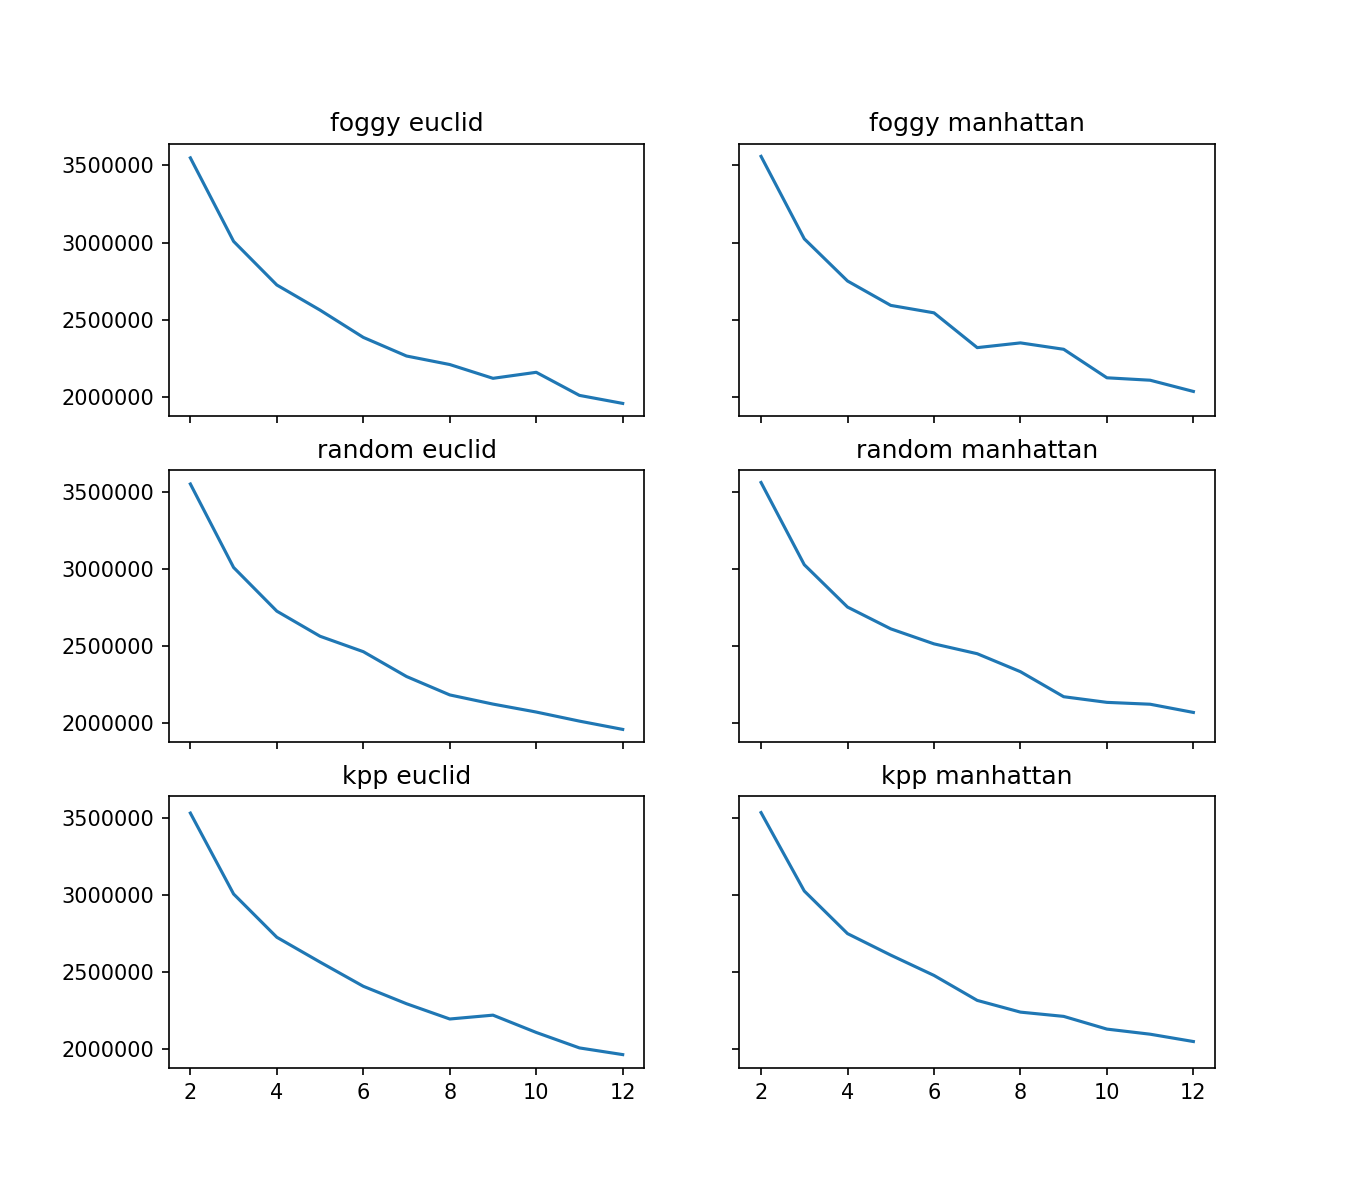

In [87]:
%matplotlib notebook
fig1,ax = plt.subplots(3, 2,sharey=True,sharex=True)
ax[0,0].plot(list(range(2, 13)),elbowScores_foggy_euclid)
ax[0,0].set_title("foggy euclid")
ax[0,1].plot(list(range(2, 13)),elbowScores_foggy_man)
ax[0,1].set_title("foggy manhattan")
ax[1,0].plot(list(range(2, 13)),elbowScores_random_euclid)
ax[1,0].set_title('random euclid')
ax[1,1].plot(list(range(2, 13)),elbowScores_random_man)
ax[1,1].set_title('random manhattan')
ax[2,0].plot(list(range(2, 13)),elbowScores_kpp_euclid)
ax[2,0].set_title('kpp euclid')
ax[2,1].plot(list(range(2, 13)),elbowScores_kpp_man)
ax[2,1].set_title('kpp manhattan')
fig1.set_size_inches(9, 8) 

## Observations from above plots
 - There error does not much change between euclid or manhattan distance
 - The elbow method suggest that k value should be 8 or 9 or 10
 - Let us look at silhoutte scores to figure out

In [35]:
classifiers_foggy_euclidean[6].getSilhouteScore()

0.15193276055025431

In [277]:
classifiers_foggy_euclidean[7].getSilhouteScore()
classifiers_foggy_euclidean[8].getSilhouteScore()

0.14111233675272378

In [281]:
classifiers_foggy_euclidean[9].getSilhouteScore()
classifiers_foggy_euclidean[10].getSilhouteScore()

0.14143552179300958

<IPython.core.display.Javascript object>


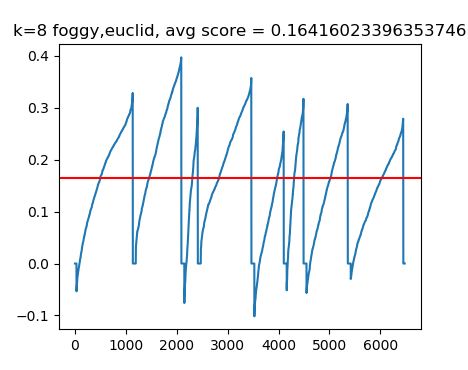

In [292]:
plotShiloute(classifiers_foggy_euclidean[6],"k=8 foggy,euclid, avg score = "+str(classifiers_foggy_euclidean[6].silhouteScore))

<IPython.core.display.Javascript object>


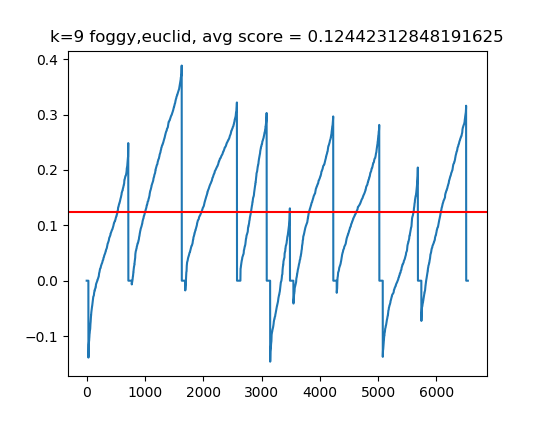

In [293]:
plotShiloute(classifiers_foggy_euclidean[7],"k=9 foggy,euclid, avg score = "+str(classifiers_foggy_euclidean[7].silhouteScore))

<IPython.core.display.Javascript object>


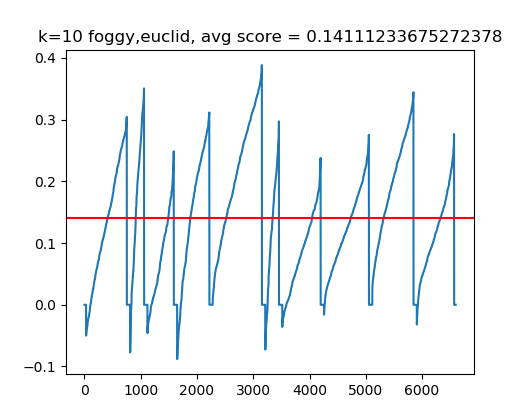

In [302]:
plotShiloute(classifiers_foggy_euclidean[8],"k=10 foggy,euclid, avg score = "+str(classifiers_foggy_euclidean[8].silhouteScore))

<IPython.core.display.Javascript object>


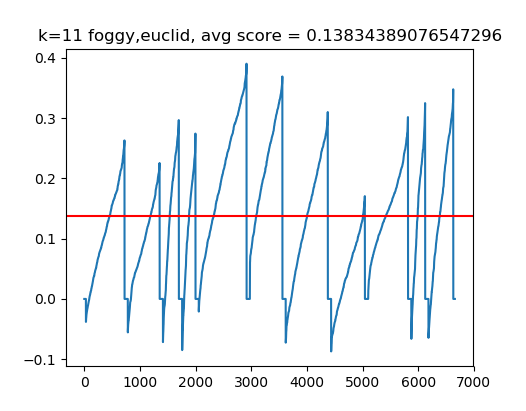

In [295]:
plotShiloute(classifiers_foggy_euclidean[9],"k=11 foggy,euclid, avg score = "+str(classifiers_foggy_euclidean[9].silhouteScore))

<IPython.core.display.Javascript object>


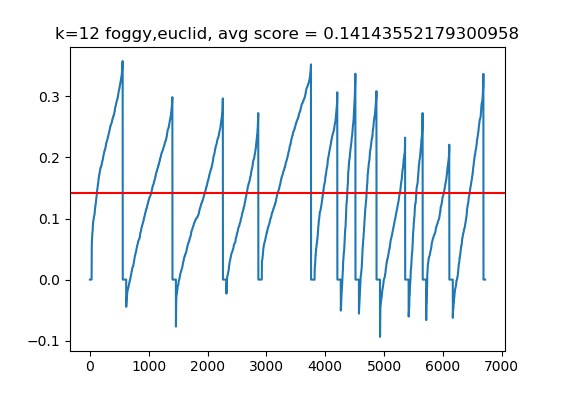

In [296]:
plotShiloute(classifiers_foggy_euclidean[10],"k=12 foggy,euclid, avg score = "+str(classifiers_foggy_euclidean[10].silhouteScore))

## Not plotting all the silhoute plots as it is taking lot of time. But from above graphs for k=8 we got the highest avg silhoutte score and all clusters are well divided.

## Selecting K=10 for the purposes of classification as we already know the labels

In [113]:
final_initialPoints_kmeansPlusPlus = kmeansPlusPlus(X_train,10)
final_classifier = Kmeans(X_train,final_initialPoints_kmeansPlusPlus)
final_classifier.train()

## plotting the centroids

<IPython.core.display.Javascript object>


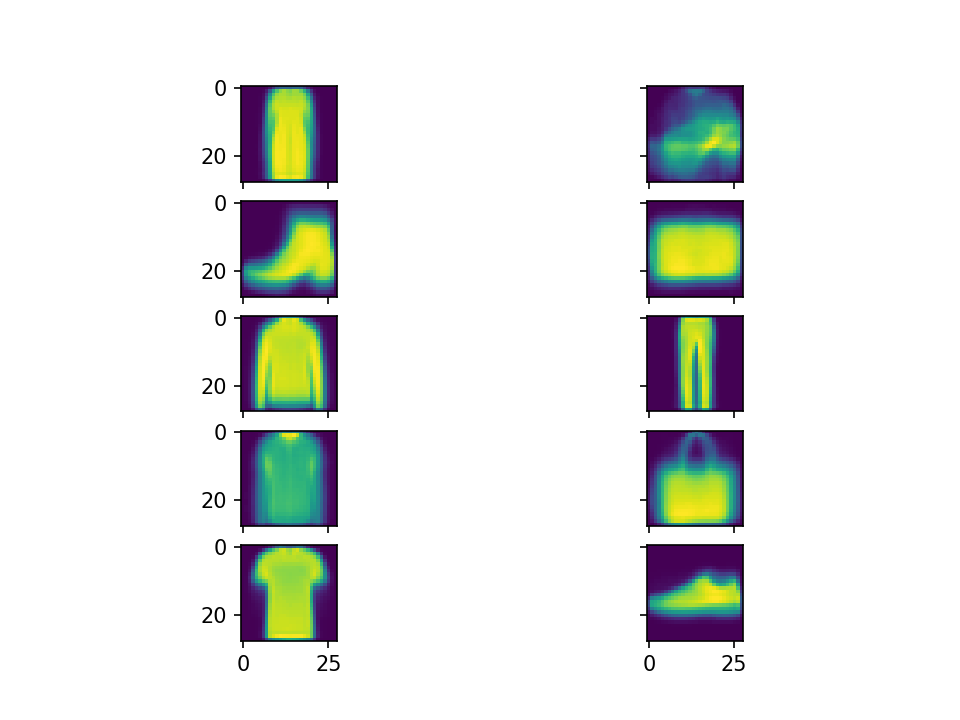

In [136]:
fig2,ax1 = plt.subplots(5, 2,sharey=True,sharex=True)
ax1[0,0].imshow(final_classifier.initialPoints[0].reshape(28,28))
ax1[0,1].imshow(final_classifier.initialPoints[1].reshape(28,28))
ax1[1,0].imshow(final_classifier.initialPoints[2].reshape(28,28))
ax1[1,1].imshow(final_classifier.initialPoints[3].reshape(28,28))
ax1[2,0].imshow(final_classifier.initialPoints[4].reshape(28,28))
ax1[2,1].imshow(final_classifier.initialPoints[5].reshape(28,28))
ax1[3,0].imshow(final_classifier.initialPoints[6].reshape(28,28))
ax1[3,1].imshow(final_classifier.initialPoints[7].reshape(28,28))
ax1[4,0].imshow(final_classifier.initialPoints[8].reshape(28,28))
ax1[4,1].imshow(final_classifier.initialPoints[9].reshape(28,28))

In [115]:
def getLabelsForCentroids(X_train,y_train,centroids):
    labelCount = [[0 for i in range(10)] for j in range(10)]
    for i in range(X_train.shape[0]):
        distanceArray = getDistanceArray(X_train[i],centroids,'euclidean')
        centroidNum = np.argmin(distanceArray)
        labelCount[centroidNum][y_train[i]] += 1
    labels = [a.index(max(a)) for a in labelCount]
    return labels

In [116]:
centroidLabels = getLabelsForCentroids(X_train,y_train,final_classifier.initialPoints)
print(centroidLabels)

[3, 5, 9, 8, 4, 1, 6, 8, 0, 7]


## writing logic to predict labels

In [117]:
def predict(inputImage,centroids,centroidLabels):
    distanceArray = getDistanceArray(inputImage,centroids,'euclidean')
    centroidNum = np.argmin(distanceArray)
    return centroidLabels[centroidNum]

In [118]:
def getAccuracy(X_val,y_val,final_classcentroidLabelsr,centroidLabels):
    countCorr = 0
    predictions = []
    for i in range(X_val.shape[0]):
        predLabel = predict(X_val[i],final_classifier.initialPoints,centroidLabels)
        predictions.append(predLabel)
        if(predLabel == y_val[i]):
            countCorr += 1
    accuracy = (countCorr/X_val.shape[0])*100
    return accuracy,predictions

In [120]:
from sklearn.metrics.cluster import homogeneity_score
train_accuracy,train_pred = getAccuracy(X_train,y_train,final_classifier,centroidLabels)
train_homo_score = homogeneity_score(y_train ,train_pred)
val_accuracy,val_pred = getAccuracy(X_val,y_val,final_classifier,centroidLabels)
val_homo_score = homogeneity_score(y_val ,val_pred)
test_accuracy,test_pred = getAccuracy(testX,testy,final_classifier,centroidLabels)
test_homo_score = homogeneity_score(testy ,test_pred)

In [122]:
from prettytable import PrettyTable
t = PrettyTable(['','training ', 'validation ','test'])
t.add_row(['accuracy', train_accuracy,val_accuracy,test_accuracy])
t.add_row(['homogenity Score', train_homo_score,val_homo_score,test_homo_score])
print(t)

+------------------+--------------------+--------------------+--------------------+
|                  |     training       |    validation      |        test        |
+------------------+--------------------+--------------------+--------------------+
|     accuracy     | 59.22142857142857  | 59.52222222222222  | 60.099999999999994 |
| homogenity Score | 0.5242076402112423 | 0.5249097035507608 | 0.5254341964817216 |
+------------------+--------------------+--------------------+--------------------+


# TSNE Plot 

<IPython.core.display.Javascript object>


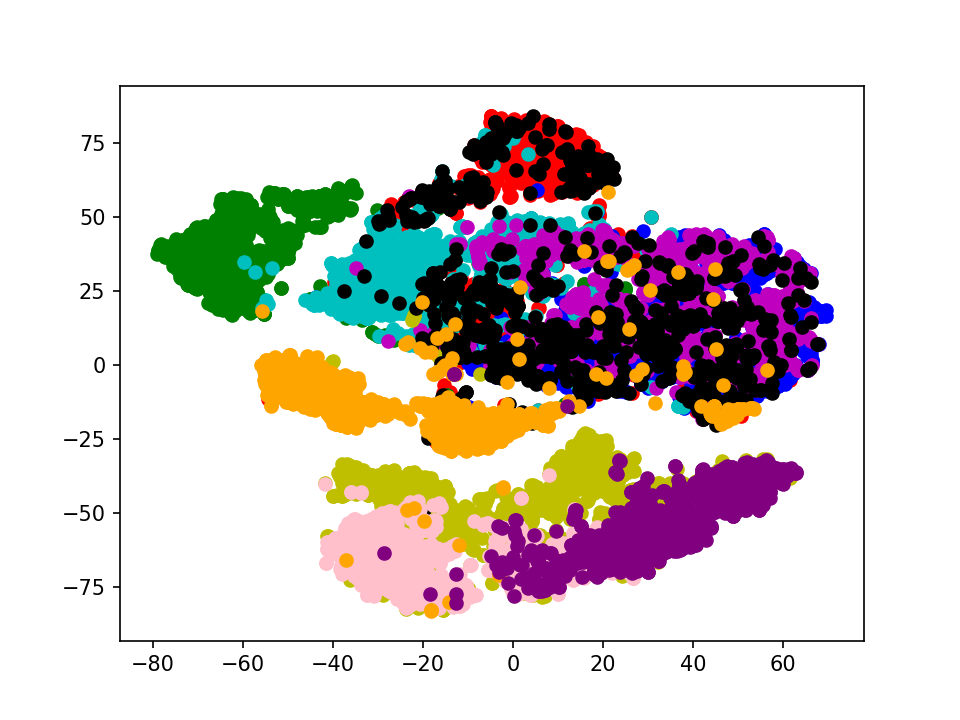

In [138]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=0)

X_2d = tsne.fit_transform(X_train)

target_ids = range(10)
colors = 'r', 'g', 'b', 'c', 'm', 'y', 'k', 'pink', 'orange', 'purple'
plt.figure()
for i, c, in zip(target_ids, colors):
    plt.scatter(X_2d[y_train == i, 0], X_2d[y_train == i, 1], c=c)
plt.show()

# Using sklearn Kmeans

In [141]:
from sklearn.cluster import KMeans
sklearnElbowScores = []
for k in range(1,13):
    kmeans = KMeans(n_clusters=k, random_state=0).fit(X_train)
    sklearnElbowScores.append(kmeans.inertia_)

<IPython.core.display.Javascript object>


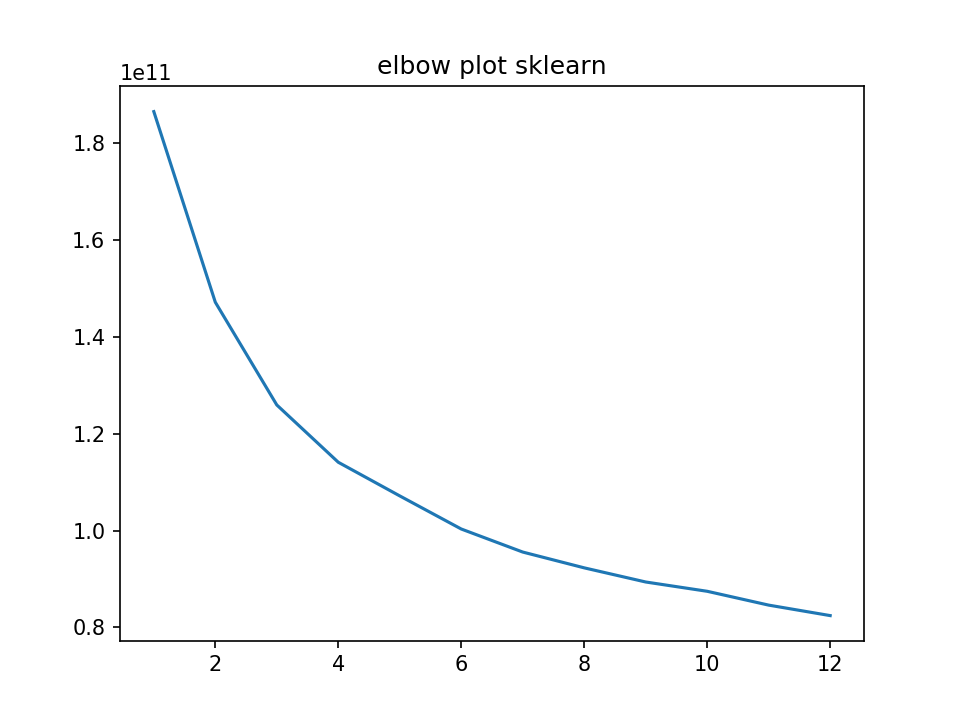

In [142]:
plt.figure()
plt.title("elbow plot sklearn")
plt.plot(list(range(1, 13)),sklearnElbowScores)

In [153]:
from sklearn import metrics
kmeans = KMeans(n_clusters=10).fit(X_train)

In [155]:
kmeans.cluster_centers_

array([[ 3.73427673e-03,  1.25786164e-02,  8.45125786e-02, ...,
         7.74371069e-02,  1.59198113e-02,  3.53773585e-03],
       [-7.16657636e-17,  1.03244838e-02,  1.03244838e-02, ...,
         5.84636185e+00,  2.74655851e+00,  1.94198623e-01],
       [ 2.66666667e-03,  4.38095238e-03,  9.90476190e-03, ...,
         3.05600000e+00,  1.21676190e+00,  7.63809524e-02],
       ...,
       [ 3.70988685e-04,  6.86329067e-03,  6.34390651e-02, ...,
         2.41105546e+00,  5.17343721e-01,  6.26970877e-02],
       [ 2.35271871e-17,  1.89993667e-03,  5.03069808e-16, ...,
         3.19189360e-01,  3.62887904e-01,  8.67637745e-02],
       [-1.53956708e-17, -3.80771803e-16,  2.91433544e-16, ...,
        -2.24265051e-13,  9.48130463e-14, -6.73072709e-15]])

In [156]:
centroidLabels_sk = getLabelsForCentroids(X_train,y_train,kmeans.cluster_centers_)
print(centroidLabels_sk)

[0, 9, 5, 8, 2, 4, 1, 6, 8, 7]


In [169]:
def getAccuracy_sk(X_val,y_val,centroids,centroidLabels):
    countCorr = 0
    predictions = []
    for i in range(X_val.shape[0]):
        predLabel = predict(X_val[i],centroids,centroidLabels)
        predictions.append(predLabel)
        if(predLabel == y_val[i]):
            countCorr += 1
    accuracy = (countCorr/X_val.shape[0])*100
    return accuracy,predictions

In [170]:
from sklearn.metrics.cluster import homogeneity_score
train_accuracy_sk,train_pred_sk = getAccuracy_sk(X_train,y_train,kmeans.cluster_centers_,centroidLabels_sk)
train_homo_score_sk = homogeneity_score(y_train ,train_pred_sk)

val_accuracy_sk,val_pred_sk = getAccuracy_sk(X_val,y_val,kmeans.cluster_centers_,centroidLabels_sk)
val_homo_score_sk = homogeneity_score(y_val ,val_pred_sk)

test_accuracy_sk,test_pred_sk = getAccuracy_sk(testX,testy,kmeans.cluster_centers_,centroidLabels_sk)
test_homo_score_sk = homogeneity_score(testy ,test_pred_sk)

In [174]:
from prettytable import PrettyTable
t = PrettyTable(['SKLEARN','training ', 'validation ','test'])
t.add_row(['accuracy', train_accuracy_sk,val_accuracy_sk,test_accuracy_sk])
t.add_row(['homogenity Score', train_homo_score_sk,val_homo_score_sk,test_homo_score_sk])
t.add_row(['Slef Implementation','training ', 'validation ','test'])
t.add_row(['accuracy', train_accuracy,val_accuracy,test_accuracy])
t.add_row(['homogenity Score', train_homo_score,val_homo_score,test_homo_score])
print(t)

+---------------------+--------------------+--------------------+--------------------+
|       SKLEARN       |     training       |    validation      |        test        |
+---------------------+--------------------+--------------------+--------------------+
|       accuracy      | 57.22380952380952  | 57.90555555555555  | 57.93000000000001  |
|   homogenity Score  | 0.5033407820886123 | 0.5048860513058729 | 0.5046163433556397 |
| Slef Implementation |     training       |    validation      |        test        |
|       accuracy      | 59.22142857142857  | 59.52222222222222  | 60.099999999999994 |
|   homogenity Score  | 0.5242076402112423 | 0.5249097035507608 | 0.5254341964817216 |
+---------------------+--------------------+--------------------+--------------------+


# Part 2 working with latent space representation

In [187]:
import pandas as pd
df = pd.read_csv('data.csv',header=None)
df[0] = df[0].apply(lambda x:x[1:])
df[191] = df[191].apply(lambda x:x[:-1])
df.head()

,0,1,2,3,4,5,6,7,8,9,...,183,184,185,186,187,188,189,190,191,192
0,1.0866963863372803,2.371966,5.534521,3.771174,1.877307,3.599094,5.784208,3.871398,2.878446,4.109515,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Ankle Boot
1,5.086210250854492,3.526383,3.173435,3.100720,4.561333,4.389340,3.113444,2.403284,4.039598,5.388708,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,T-Shirt
2,1.211804747581482,2.946491,2.014766,0.606742,1.302111,2.517385,1.538354,0.719057,1.375769,2.441072,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,T-Shirt
3,3.1817357540130615,3.386448,1.852063,1.134460,2.596234,3.389648,1.662953,1.038565,2.676021,3.362122,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Dress
4,3.5364575386047363,5.801409,3.549685,1.483723,3.400284,6.017810,3.560772,0.938271,3.958203,6.236764,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,T-Shirt


In [188]:
data_train = df.iloc[:,:-1].values
data_train = data_train.astype(np.float)

In [189]:
data_train, data_test, y_train, y_test = train_test_split(data_train, trainy, test_size=0.3, random_state=42)

In [190]:
data_train.shape

(42000, 192)

In [177]:
classifiers_foggy_euclidean_data = []
classifiers_rand_euclidean_data = []
classifiers_kpp_euclidean_data = []
classifiers_foggy_man_data = []
classifiers_rand_man_data = []
classifiers_kpp_man_data = []
for k in range(2,13):
    initialPoints_foggy_data = forgyInitialization(data_train,k)
    initialPoints_rand_data = randomPartitionMethod(data_train,k)
    initialPoints_kmeansPlusPlus_data = kmeansPlusPlus(data_train,k)
    
    classifier_foggy_euclid_data = Kmeans(data_train,initialPoints_foggy_data)
    classifier_foggy_euclid_data.train()
    classifier_foggy_man_data = Kmeans(data_train,initialPoints_foggy_data,'manhattan')
    classifier_foggy_man_data.train()
    
    classifier_random_euclid_data = Kmeans(data_train,initialPoints_rand_data)
    classifier_random_euclid_data.train()
    classifier_random_man_data = Kmeans(data_train,initialPoints_rand_data,'manhattan')
    classifier_random_man_data.train()
    
    
    classifier_kpp_euclid_data = Kmeans(data_train,initialPoints_kmeansPlusPlus_data)
    classifier_kpp_euclid_data.train()
    classifier_kpp_man_data = Kmeans(data_train,initialPoints_kmeansPlusPlus_data,'manhattan')
    classifier_kpp_man_data.train()
    
    classifiers_foggy_euclidean_data.append(classifier_foggy_euclid_data)
    classifiers_foggy_man_data.append(classifier_foggy_man_data)
    
    classifiers_rand_euclidean_data.append(classifier_random_euclid_data)
    classifiers_rand_man_data.append(classifier_random_man_data)
    
    classifiers_kpp_euclidean_data.append(classifier_kpp_euclid_data)
    classifiers_kpp_man_data.append(classifier_kpp_man_data)

In [180]:
elbowScores_foggy_euclid_data = []
elbowScores_foggy_man_data = []
elbowScores_random_euclid_data = []
elbowScores_random_man_data = []
elbowScores_kpp_euclid_data = []
elbowScores_kpp_man_data = []
for i in range(len(classifiers_foggy_euclidean_data)):
    elbowScores_foggy_euclid_data.append(classifiers_foggy_euclidean_data[i].getSMM())
    elbowScores_foggy_man_data.append(classifiers_foggy_man_data[i].getSMM())
    elbowScores_random_euclid_data.append(classifiers_rand_euclidean_data[i].getSMM())
    elbowScores_random_man_data.append(classifiers_rand_man_data[i].getSMM())
    elbowScores_kpp_euclid_data.append(classifiers_kpp_euclidean_data[i].getSMM())
    elbowScores_kpp_man_data.append(classifiers_kpp_man_data[i].getSMM())

<IPython.core.display.Javascript object>


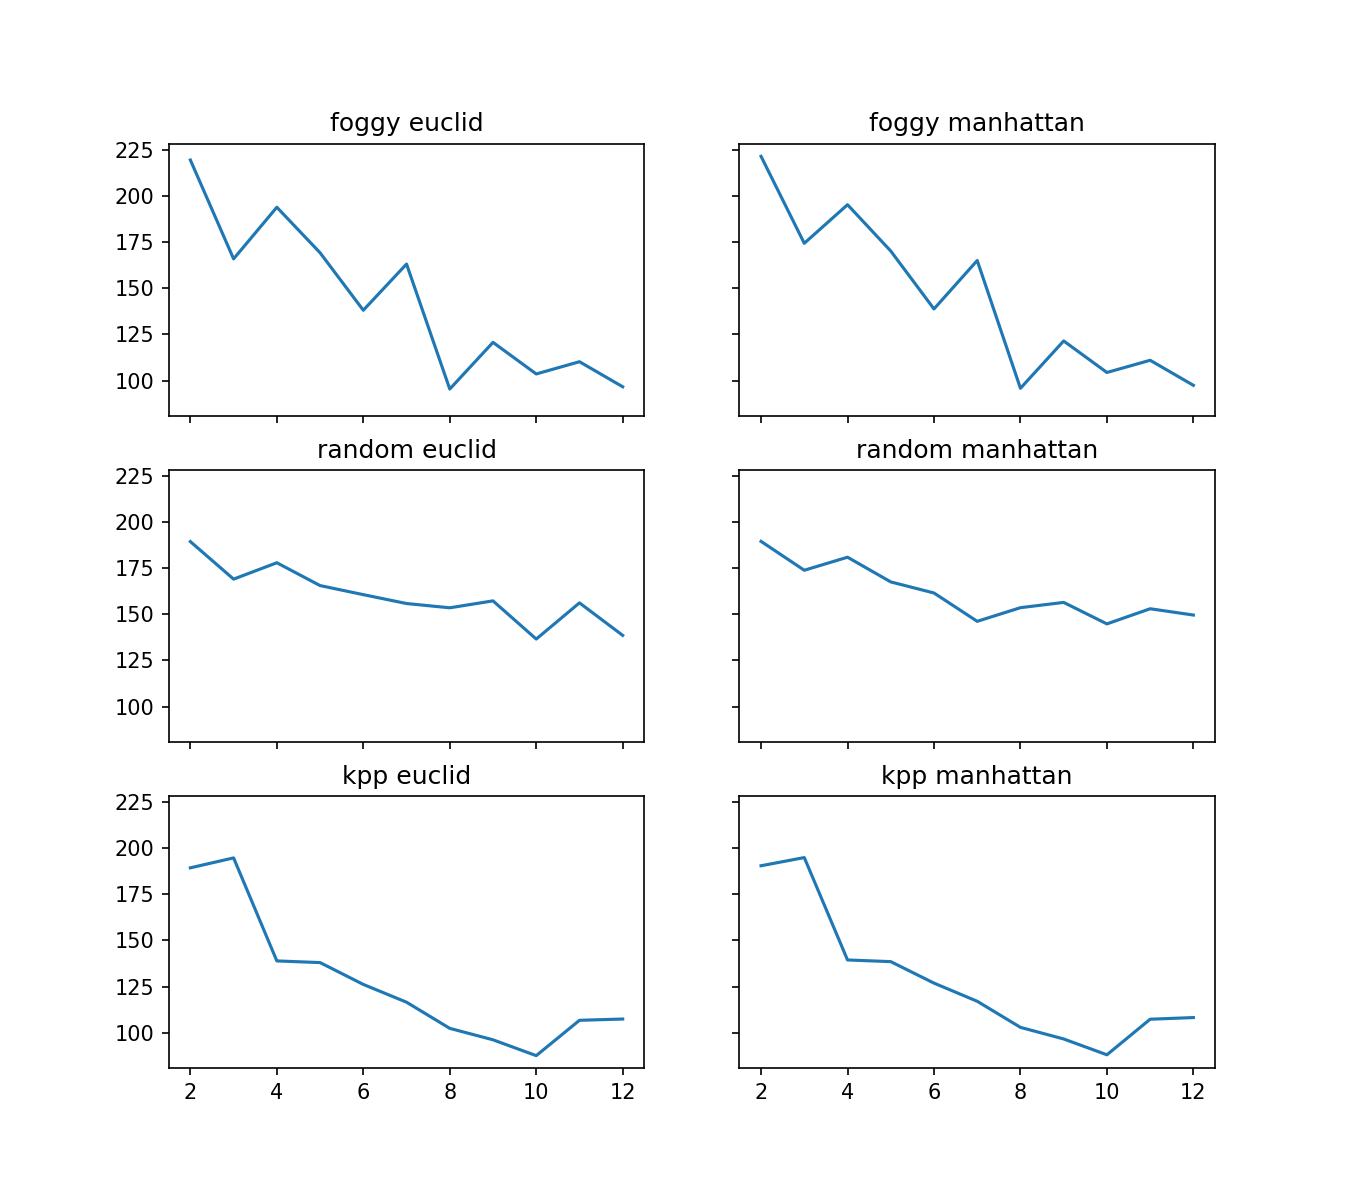

In [181]:
%matplotlib notebook
fig1,ax1 = plt.subplots(3, 2,sharey=True,sharex=True)
ax1[0,0].plot(list(range(2, 13)),elbowScores_foggy_euclid_data)
ax1[0,0].set_title("foggy euclid")
ax1[0,1].plot(list(range(2, 13)),elbowScores_foggy_man_data)
ax1[0,1].set_title("foggy manhattan")
ax1[1,0].plot(list(range(2, 13)),elbowScores_random_euclid_data)
ax1[1,0].set_title('random euclid')
ax1[1,1].plot(list(range(2, 13)),elbowScores_random_man_data)
ax1[1,1].set_title('random manhattan')
ax1[2,0].plot(list(range(2, 13)),elbowScores_kpp_euclid_data)
ax1[2,0].set_title('kpp euclid')
ax1[2,1].plot(list(range(2, 13)),elbowScores_kpp_man_data)
ax1[2,1].set_title('kpp manhattan')
fig1.set_size_inches(9, 8) 

# Selecting k=10

In [195]:
latent_initialPoints_kmeansPlusPlus = kmeansPlusPlus(data_train,10)
latent_classifier = Kmeans(data_train,latent_initialPoints_kmeansPlusPlus)
latent_classifier.train()

In [196]:
latent_centroidLabels = getLabelsForCentroids(data_train,y_train,latent_classifier.initialPoints)
print(latent_centroidLabels)

[0, 7, 4, 9, 3, 5, 2, 6, 8, 1]


In [199]:
latent_classifier.initialPoints.shape

(10, 192)

In [202]:
latent_train_accuracy,latent_train_pred = getAccuracy_sk(data_train,y_train,latent_classifier.initialPoints,latent_centroidLabels)
latent_train_homo_score = homogeneity_score(y_train ,latent_train_pred)

latent_test_accuracy,latent_test_pred = getAccuracy_sk(data_test,y_test,latent_classifier.initialPoints,latent_centroidLabels)
latent_test_homo_score = homogeneity_score(y_test ,latent_test_pred)
print(latent_train_accuracy)
print(latent_test_accuracy)

44.25714285714285
44.166666666666664


In [203]:
from prettytable import PrettyTable
t = PrettyTable(['Latent Space','training ','test'])
t.add_row(['accuracy', latent_train_accuracy,latent_test_accuracy])
t.add_row(['homogenity Score', latent_train_homo_score,latent_test_homo_score])
print(t)

+------------------+--------------------+--------------------+
|   Latent Space   |     training       |        test        |
+------------------+--------------------+--------------------+
|     accuracy     | 44.25714285714285  | 44.166666666666664 |
| homogenity Score | 0.3810597880708876 | 0.3807969558523824 |
+------------------+--------------------+--------------------+


In [204]:
tsne_latent = TSNE(n_components=2, random_state=0)
X_2d_latent = tsne_latent.fit_transform(data_train)

<IPython.core.display.Javascript object>


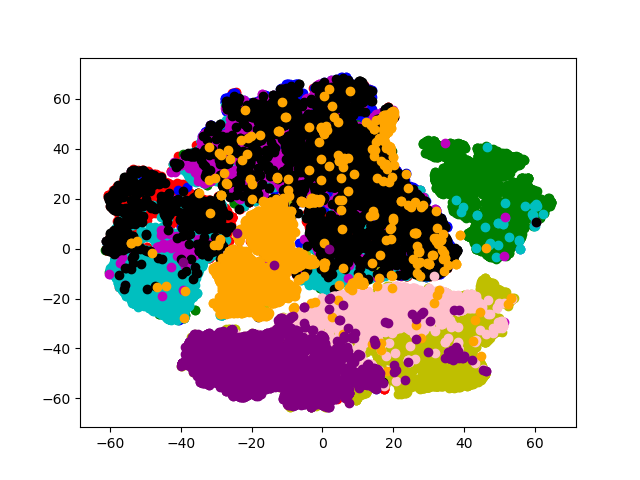

In [206]:
target_ids = range(10)
colors = 'r', 'g', 'b', 'c', 'm', 'y', 'k', 'pink', 'orange', 'purple'
plt.figure()
for i, c, in zip(target_ids, colors):
    plt.scatter(X_2d_latent[y_train == i, 0], X_2d_latent[y_train == i, 1], c=c)
plt.show()

### From these experiments(Part 1 and Part 2), compare accuracy or error, and report which one is better and why?

 - From the above experiments using the complete image gives higher accuracy compared to latent space. (57.93 ->complet,44.16 -> latent)
 - But training latent space is much faster than complete data as the number of dimensions have decreased a lot. (784 to 192)
 - I Would suggest using the complete data set, as training is a one time thing in K Means. For predicting the class we just have to compute the distances to the centroids.